读取t-shirt数据集

/mnt/ssd5/guohong/yolov3m
/mnt/ssd5/guohong/data/tshirt/train/JEPGImages/553.jpg
/mnt/ssd5/guohong/data/tshirt/train/Annotations/553.xml
[[1512  359 2177 2160]
 [ 759  548 1522 2160]] int32


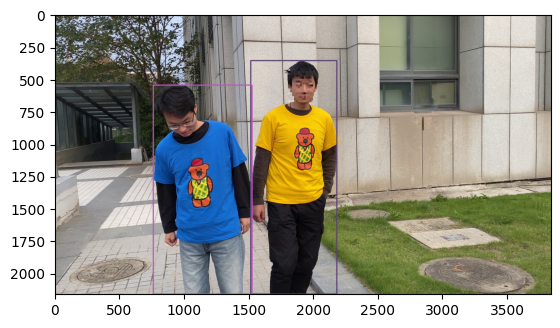

In [1]:
%reload_ext autoreload
%autoreload 2
%cd yolov3m

import random
from matplotlib import pyplot as plt
import cv2 as cv
import pathlib
import numpy as np
import xmltodict as x2d
from utils import plot_one_box

path = pathlib.Path('/mnt/ssd5/guohong/data/tshirt')

img_path = path / 'train' / 'JEPGImages'
anno_path = path / 'train' / 'Annotations'
file_names = img_path.iterdir()

for name in file_names:
    print(name)

    img = cv.imread(name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    anno_name = anno_path / str(name.stem + '.xml')
    print(anno_name)

    with open(anno_name, 'r') as f:
        data = x2d.parse(f.read())

    boxes = []
    labels = []
    for item in data['annotation']['object']:

        box = item['bndbox']
        xmin = box['xmin']
        ymin = box['ymin']
        xmax = box['xmax']
        ymax = box['ymax']
        name = item['name']
        labels.append(name)
        boxes.append([xmin, ymin, xmax, ymax])
    boxes = np.array(boxes, dtype=np.int32)

    print(boxes, boxes.dtype)

    for x in range(boxes.shape[0]):
        color = [random.randint(0,255) for _ in range(3)]
        plot_one_box(boxes[x], img, color=color)
    plt.imshow(img)
    plt.show()

    break    

T-shirt数据集的类集合

In [2]:
from collections import defaultdict
from pathlib import Path

import xmltodict as xml

path = Path('/mnt/ssd5/guohong/data/tshirt')

anno_path = path / 'train' / 'Annotations'

anno_files = anno_path.iterdir()

classes = defaultdict(bool)

for name in anno_files:
    with open(name, 'r') as f:
        data = xml.parse(f.read())['annotation']
    # print(data['filename'], end='\t')
    objs = data['object']
    if isinstance(objs, dict):
        objs = [objs]
    for item in objs:
        # print(item['name'], end='\t')
        if not(classes[item['name']]):
            classes[item['name']] = True
    # print('', end='\n')

print(classes.keys())


dict_keys(['person', 'T', 'bicycle', 'car'])


修改t-shirt数据集的xml标注文件为txt，并加到coco2014数据集中

index -- class name:
```yaml
 0: person
 1: bicycle
 2: car
```

In [ ]:
import xmltodict as xml
from pathlib import Path
import json

root = Path("/mnt/ssd5/guohong/data/tshirt/train")

anno_path = root / "Annotations"
anno_files = anno_path.iterdir()

for name in anno_files:
    with open(name, 'r') as f:
        data = xml.parse(f.read())
    print(json.dumps(data, indent=2))
    break

{
  "annotation": {
    "folder": "JPEGImages",
    "filename": "331.jpg",
    "path": "E:\\Program Files\\JetBrains\\WorkSpace\\yolo3-pytorch-master\\dataset\\JPEGImages\\331.jpg",
    "source": {
      "database": "Unknown"
    },
    "size": {
      "width": "3840",
      "height": "2160",
      "depth": "3"
    },
    "segmented": "0",
    "object": [
      {
        "name": "person",
        "pose": "Unspecified",
        "truncated": "1",
        "difficult": "0",
        "bndbox": {
          "xmin": "269",
          "ymin": "1",
          "xmax": "1472",
          "ymax": "2160"
        }
      },
      {
        "name": "T",
        "pose": "Unspecified",
        "truncated": "1",
        "difficult": "0",
        "bndbox": {
          "xmin": "1674",
          "ymin": "961",
          "xmax": "2759",
          "ymax": "2160"
        }
      }
    ]
  }
}


根据xml标准文件，制作符合coco的txt标注文件，并加入训练集

In [ ]:
from pathlib import Path
import xmltodict as xml
import sys

root = Path("/mnt/ssd5/guohong/data/tshirt/train")

root_img = root / "images"
root_anno = root / "labels"

cls_index = {
    "person": 0,
    "bicycle": 1,
    "car": 2
}

anno_files = root_anno.iterdir()
img_paths = []
# anno_paths = []
for file in anno_files:
    if file.suffix != ".xml":
        continue
    print(file)
    with open(file, "r") as f:
        data = xml.parse(f.read())["annotation"]
    name = data["filename"]

    img_paths.append(root_img / name)
    anno_path = (root_anno / name).with_suffix(".txt")
    # anno_paths.append(anno_path)

    objs = data['object']
    if isinstance(objs, dict):
        objs = [objs]
    img_w, img_h = int(data["size"]["width"]), int(data["size"]["height"])
    annos = []
    for item in objs:
        cls = item["name"]
        if cls == "T":
            continue
        cls = cls_index[cls]

        box = item["bndbox"]
        xmin = int(box["xmin"])
        ymin = int(box["ymin"])
        xmax = int(box["xmax"])
        ymax = int(box["ymax"])

        w, h = xmax - xmin, ymax - ymin
        x, y = xmin + w / 2, ymin + h / 2

        w, x = w / img_w, x / img_w
        h, y = h / img_h, y / img_h
        annos.append([cls, x, y, w, h])

    with open(anno_path, 'w') as f:
        for row in annos:
            f.write("\t".join(map(str, row)) + "\n")


with open("data/coco2014/trainvalno5k.txt", "a") as f:
    for row in img_paths:
        f.write(str(row) + "\n")



Converting the VOC data to the format of coco data.

In [ ]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path

root = Path("../data/VOCdevkit/VOC2012")

img_root = root / "images"
anno_root = root / "labels"
train_imgs = root / "ImageSets" / "Main" / "train.txt"
val_imgs = root / "ImageSets" / "Main" / "val.txt"

with open(train_imgs, 'r') as f:
    train_imgs_files = [img_root / row.strip() for row in f.readlines()]
with open(val_imgs, 'r') as f:
    val_imgs_files = [img_root / row.strip() for row in f.readlines()]

print(len(train_imgs_files), len(val_imgs_files))


5717 5823


In [5]:
root = root.absolute()
train_txt = root / "train.txt"
with open(train_txt, 'w') as f:
    for row in train_imgs_files:
        f.write(str(row) + '\n')
val_txt = root / "val.txt"
with open(val_txt, 'w') as f:
    for row in val_imgs_files:
        f.write(str(row) + '\n')

```json{
  "annotation": {
    "folder": "VOC2012",
    "filename": "2008_002676.jpg",
    "source": {
      "database": "The VOC2008 Database",
      "annotation": "PASCAL VOC2008",
      "image": "flickr"
    },
    "size": {
      "width": "500",
      "height": "375",
      "depth": "3"
    },
    "segmented": "0",
    "object": [
      {
        "name": "tvmonitor",
        "pose": "Rear",
        "truncated": "1",
        "occluded": "0",
        "bndbox": {
          "xmin": "121",
          "ymin": "209",
          "xmax": "357",
          "ymax": "375"
        },
        "difficult": "0"
      },
      {
        "name": "person",
        "pose": "Frontal",
        "truncated": "1",
        "occluded": "0",
        "bndbox": {
          "xmin": "196",
          "ymin": "123",
          "xmax": "324",
          "ymax": "213"
        },
        "difficult": "0"
      },
      {
        "name": "chair",
        "pose": "Frontal",
        "truncated": "1",
        "occluded": "1",
        "bndbox": {
          "xmin": "82",
          "ymin": "168",
          "xmax": "410",
          "ymax": "342"
        },
        "difficult": "0"
      }
    ]
  }
}
```

In [11]:
import yaml
with open("settings/VOC-names.yaml", 'r') as f:
    data = yaml.safe_load(f.read())['names']
cls_index = {}
for k, v in data.items():
    cls_index[v] = k
print(cls_index)

{'person': 0, 'bird': 1, 'cat': 2, 'cow': 3, 'dog': 4, 'horse': 5, 'sheep': 6, 'aeroplane': 7, 'bicycle': 8, 'boat': 9, 'bus': 10, 'car': 11, 'motorbike': 12, 'train': 13, 'bottle': 14, 'chair': 15, 'diningtable': 16, 'pottedplant': 17, 'sofa': 18, 'tvmonitor': 19}


In [12]:
%reload_ext autoreload
%autoreload 2

import xmltodict as xml
import json
from pathlib import Path
import random

root = Path("../data/VOCdevkit/VOC2012")

anno_root = root / "Annotations"

anno_files = list(anno_root.iterdir())
count = 0
for row in anno_files:
    if row.suffix != ".xml":
        continue
    anno_path = row.with_suffix('.txt')
    if anno_path.exists():
        continue
    with open(row, 'r') as f:
        data = xml.parse(f.read())["annotation"]
    count += 1

    objs = data['object']
    if isinstance(objs, dict):
        objs = [objs]
    img_w, img_h = int(data["size"]["width"]), int(data["size"]["height"])
    annos = []
    for item in objs:
        cls = item["name"]
        cls = cls_index[cls]

        box = item["bndbox"]
        xmin = int(box["xmin"])
        ymin = int(box["ymin"])
        xmax = int(box["xmax"])
        ymax = int(box["ymax"])

        w, h = xmax - xmin, ymax - ymin
        x, y = xmin + w / 2, ymin + h / 2

        w, x = w / img_w, x / img_w
        h, y = h / img_h, y / img_h
        annos.append([cls, x, y, w, h])
    
    with open(anno_path, 'w') as f:
        for row in annos:
            f.write("\t".join(map(str, row)) + "\n")

print(count)
img_root = root / "JPEGImages"

train = random.sample(anno_files, round(len(anno_files) * 0.8))

val = list(set(anno_files) - set(train))

with open("./train.txt", 'w') as f:
    for row in train:
        f.write(str(row.with_suffix('.jpg'))+'\n')
with open("./val.txt", 'w') as f:
    for row in val:
        f.write(str(row.with_suffix('.jpg'))+'\n')


    

17125


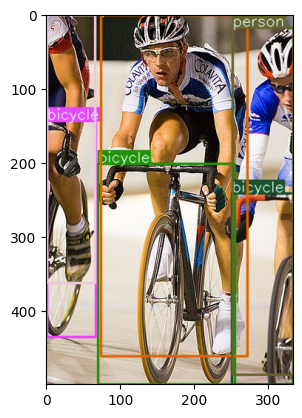

In [40]:
from turtle import width
import cv2
import numpy as np
from utils import plot_one_box
from matplotlib import pyplot as plt
import random

img_path = "../data/VOCdevkit/VOC2012/images/2007_000129.jpg"
anno_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

with open(anno_path, 'r') as f:
    # anno = 
    anno = np.array([row.strip('').split() for row in f.readlines()], dtype=np.float32)

height, width = img.shape[:2]

anno[:, 1] *= width
anno[:, 3] *= width
anno[:, 2] *= height
anno[:, 4] *= height
anno_ = anno.copy()
anno_[:, 1] = anno[:, 1] - anno[:, 3] / 2
anno_[:, 2] = anno[:, 2] - anno[:, 4] / 2
anno_[:, 3] = anno[:, 1] + anno[:, 3] / 2
anno_[:, 4] = anno[:, 2] + anno[:, 4] / 2

with open("settings/VOC-names.yaml", 'r') as f:
    classes = yaml.safe_load(f.read())["names"]

for i in range(anno_.shape[0]):
    color = [random.randint(0,255) for _ in range(3)]
    plot_one_box(anno_[i][1:], img, color=color, label=classes[int(anno_[i][0])])

plt.imshow(img)
plt.show()